# MLDA for the Basin using `gpuocean.dataassimilation.MLEnKF`

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common, WindStress
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Basin utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinPlot import * 

## Data Assimilation

In [6]:
from utils.BasinSL import *

In [7]:
ls = [6, 7, 8, 9, 10]

In [8]:
args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [9]:
from utils.BasinParameters import * 

In [10]:
data_args_list = []

for l_idx in range(len(ls)):
    data_args_list.append( make_init_steady_state(args_list[l_idx], a=steady_state_bump_a, bump_fractal_dist=steady_state_bump_fractal_dist) )


### Truth

In [11]:
truth = make_sim(args_list[-1], sample_args=sample_args, init_fields=data_args_list[-1])
init_mekl = ModelErrorKL.ModelErrorKL(**args_list[-1], **init_model_error_basis_args)
init_mekl.perturbSim(truth)

In [12]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)

In [13]:
obs_x, obs_y = obs_xs[0], obs_ys[0]
Hx, Hy = SLobsCoord2obsIdx(truth, obs_x, obs_y)

In [14]:
obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

Text(0.5, 0.85, 'Truth')

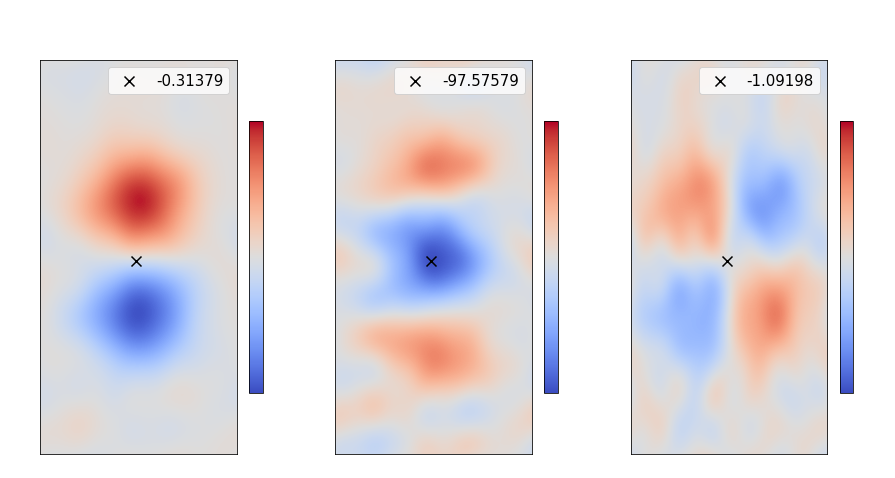

In [15]:
fig, axs = imshow3([true_eta, true_hu, true_hv], eta_vlim=3, huv_vlim=100)
axs[0].scatter(Hx,Hy, marker="x", c="black", label=str(round(obs[0],5)), s=100)
axs[0].legend(labelcolor="black", fontsize=15)
axs[1].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[1],5)), s=100)
axs[1].legend(labelcolor="black", fontsize=15)
axs[2].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[2],5)), s=100)
axs[2].legend(labelcolor="black", fontsize=15)
fig.suptitle("Truth", y=0.85)


### Multi-level Ensemble

In [16]:
Nes = [100, 75, 50, 25, 10]

In [17]:
from gpuocean.ensembles import MultiLevelOceanEnsembleCase
MLOceanEnsemble = MultiLevelOceanEnsembleCase.MultiLevelOceanEnsemble(Nes, args_list, data_args_list, sample_args, make_sim, 
                                                                      init_model_error_basis_args, sim_model_error_basis_args, sim_model_error_timestep, 
                                                                      init_xorwow_seed=0, init_np_seed=0, sim_xorwow_seed=1, sim_np_seed=1)


In [18]:
ML_prior_state = copy.deepcopy(MLOceanEnsemble.download())

In [19]:
def plot_ML_K(ML_K):
    vlims = [[1, 0.01, 0.01],[10, 1, 1],[10, 1, 1]]

    obs_varN = obs_var.stop-obs_var.start
    obs_varIdx = np.arange(obs_var.start, obs_var.stop)

    fig, axs = plt.subplots(obs_varN, 3, figsize=(10,5*obs_varN))

    for i in range(obs_varN):
        if obs_varN > 1:
            ML_K_field = ML_K[:,i].reshape(3, args_list[-1]["ny"], args_list[-1]["nx"])
        else:
            ML_K_field = ML_K
        
        for j in range(3):
            if obs_varN == 1:
                ax = axs[j]
            elif obs_varN > 1:
                ax = axs[i,j]
                
            im = ax.imshow(ML_K_field[j,:,:], vmin=-vlims[j][obs_varIdx[i]],vmax=vlims[j][obs_varIdx[i]], cmap="coolwarm")
            ax.scatter(Hx, Hy, marker="x", c="black")
            plt.colorbar(im, ax=ax, shrink=0.5)

    fig.suptitle("Kalman Gain", y=0.9)

In [20]:
from gpuocean.dataassimilation import MLEnKFOcean
MLEnKF = MLEnKFOcean.MLEnKFOcean(MLOceanEnsemble)

Classical Kalman Gain

In [21]:
ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, obs_x, obs_y, R, obs_var=slice(1,3))

[21.040684 27.269266]


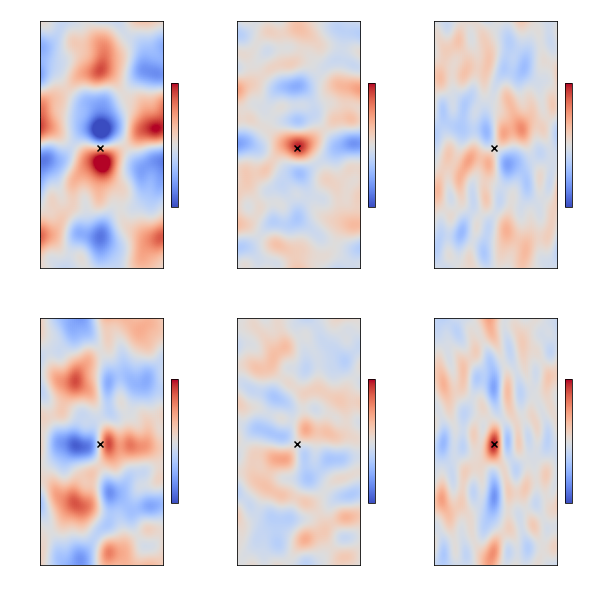

In [22]:
plot_ML_K(ML_K)

Influence of localisation (on all levels)

In [23]:
MLOceanEnsemble.upload(ML_prior_state)

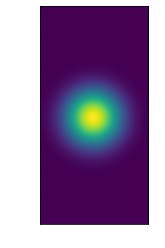

In [24]:
GC = MLEnKF.GCweights(obs_x, obs_y, r)
plt.imshow(GC, vmin=0, vmax=1)

In [25]:
ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, obs_x, obs_y, R, obs_var=slice(1,3), precomp_GC=GC, min_localisation_level=0)

[21.040684 27.269266]


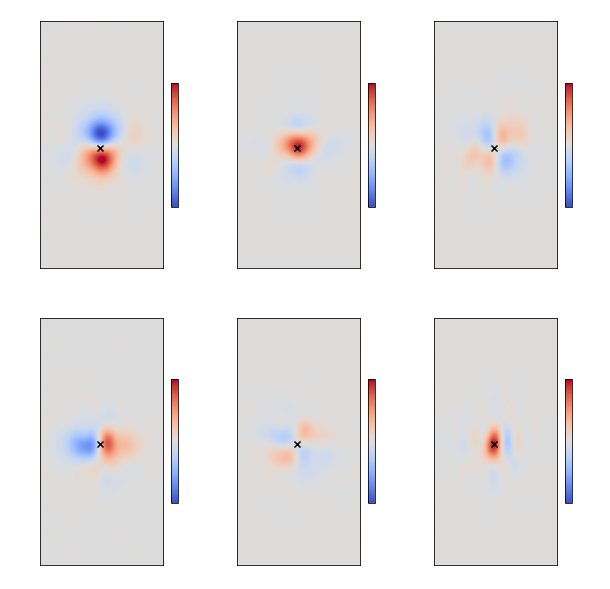

In [26]:
plot_ML_K(ML_K)

Influence of localisation (on higher levels only)

In [27]:
MLOceanEnsemble.upload(ML_prior_state)

In [28]:
ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, obs_x, obs_y, R, obs_var=slice(1,3), precomp_GC=GC, min_localisation_level=1)

[21.040684 27.269266]


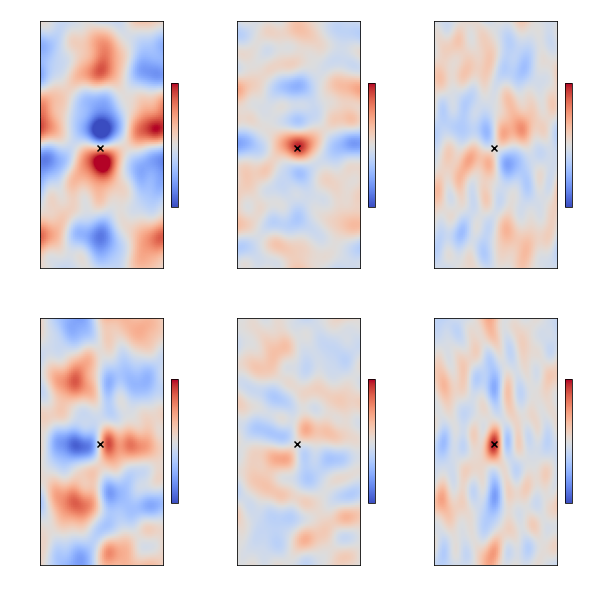

In [29]:
plot_ML_K(ML_K)

Influence of relaxation

In [30]:
MLOceanEnsemble.upload(ML_prior_state)

In [31]:
ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, obs_x, obs_y, R, obs_var=slice(1,3), precomp_GC=GC, min_localisation_level=1, relax_factor=0.5)

[21.040684 27.269266]


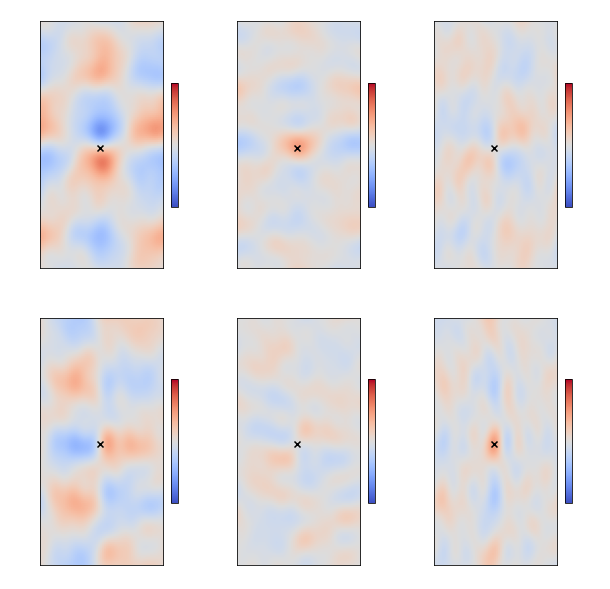

In [32]:
plot_ML_K(ML_K)

In [33]:
ML_K.max()

0.4918767875593383

Inlfuence of R 

In [34]:
MLOceanEnsemble.upload(ML_prior_state)

In [35]:
ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, obs_x, obs_y, np.array([5,50,50]), obs_var=slice(1,3))


[21.040684 27.269266]


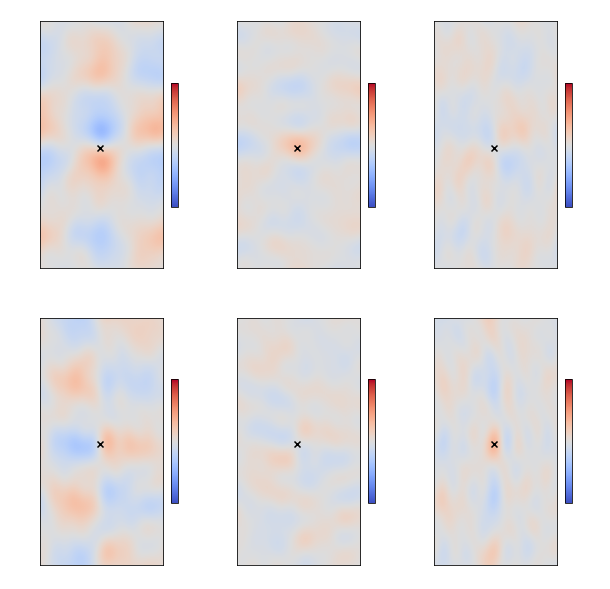

In [36]:
plot_ML_K(ML_K)